In [141]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile, mkdir
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from scipy.stats import linregress
# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


print (glob.glob("../geom_aligned_curves/*.npy"))
# curve_bs = np.array(curve_bs)
curve_bs = np.load("../geom_aligned_curves/geomstats_aligned_to_first.npy")
curve_cs = np.load("../geom_aligned_curves/geomstats_aligned_to_frechet.npy")
unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves/total_files_with_a.npy")[:curve_bs.shape[0]]

print (curve_bs.shape)
print (curve_cs.shape)
print (unaligned_curvatures.shape)
print (files.shape)

brava_num = 79

k_sampling_points = 120

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=False
)

curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_cs)

mean_estimate = mean.estimate_

tangent_base = mean.estimate_

['../geom_aligned_curves\\curvatures.npy', '../geom_aligned_curves\\geomstats_aligned_to_first.npy', '../geom_aligned_curves\\geomstats_aligned_to_first_with_a.npy', '../geom_aligned_curves\\geomstats_aligned_to_frechet.npy', '../geom_aligned_curves\\geomstats_aligned_to_frechet_with_a.npy', '../geom_aligned_curves\\total_files_with_a.npy']
(79, 119, 3)
(79, 119, 3)
(79, 120)
(79,)


- The first curve is not aligned in `curve_bs`.
- `curve_bs` and `curve_cs` have the same parameterization.

(79, 119, 3)


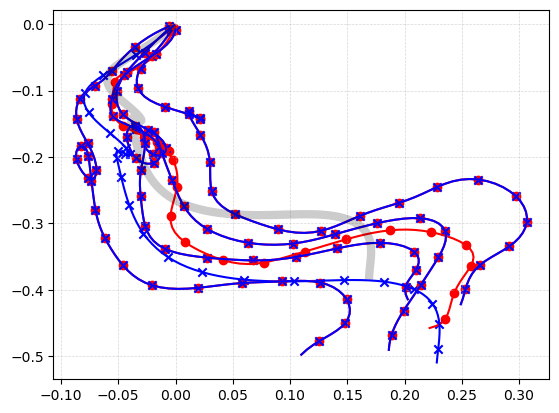

In [142]:
print (curve_bs.shape)
for i in range(5):
    plt.plot(curve_bs[i,:,0],curve_bs[i,:,1],c='r')
    plt.plot(curve_cs[i,:,0],curve_cs[i,:,1],c='b')
    plt.scatter(curve_bs[i,::5,0],curve_bs[i,::5,1],c='r')
    plt.scatter(curve_cs[i,::5,0],curve_cs[i,::5,1],c='b',marker='x')
plt.plot(mean_estimate[:,0],mean_estimate[:,1],c='k', linewidth=6, alpha=0.2)
plt.grid(linewidth=0.5, linestyle='--', alpha=0.5)
plt.show()

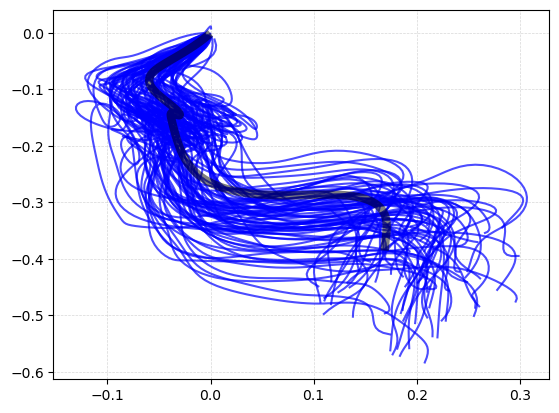

In [143]:

for i in range(curve_bs.shape[0]):
    plt.plot(curve_cs[i,:,0],curve_cs[i,:,1],c='b', alpha=0.7)
    # plt.scatter(curve_cs[i,::6,0],curve_cs[i,::6,1],c='b',marker='o', alpha=0.7)
plt.plot(mean_estimate[:,0],mean_estimate[:,1],c='k', linewidth=6, alpha=0.5)
plt.grid(linewidth=0.5, linestyle='--', alpha=0.5)
plt.show()

d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


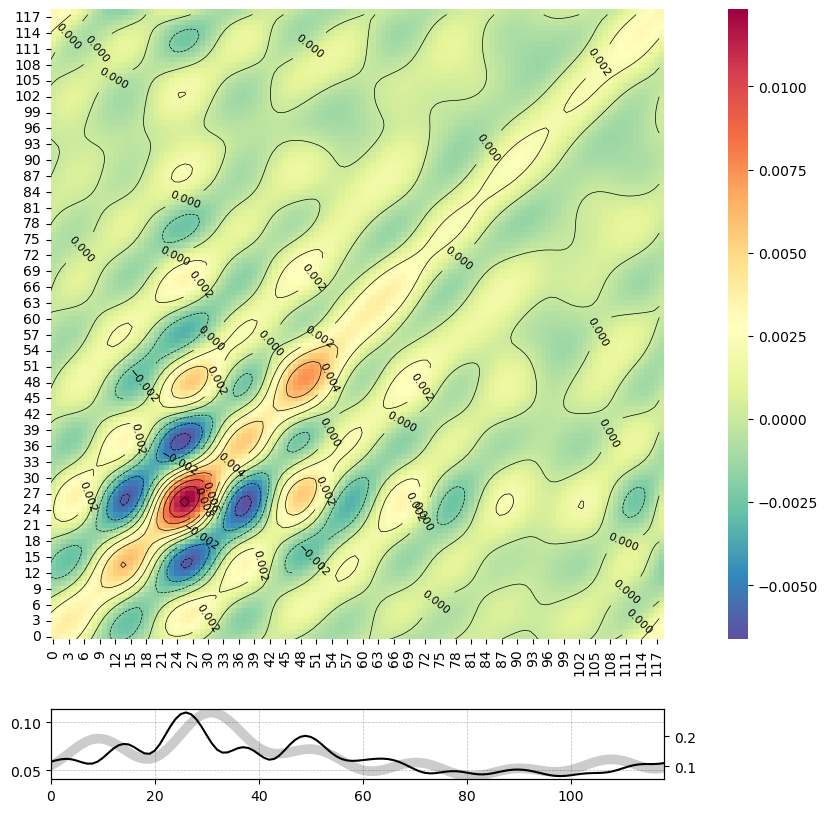

In [144]:
import numpy as np
import matplotlib.gridspec as gridspec

def compute_tortuosity(curve):
    """
    计算曲线的扭曲度
    """
    # 计算曲线的长度
    curve_length = np.sum(np.linalg.norm(np.diff(curve, axis=0), axis=1))
    # 计算曲线的欧式距离
    euclidean_distance = np.linalg.norm(curve[-1] - curve[0])
    # 计算扭曲度
    tortuosity = curve_length / euclidean_distance
    return tortuosity

def autocovariance_function(curvatures):
    """
    Compute the sample autocovariance function for a set of curvature profiles.

    Parameters:
    - curvatures: A (k, n) numpy array where k is the number of curvature profiles and
                  n is the number of points in each profile.

    Returns:
    - A (n, n) numpy array containing the sample autocovariance values for the curvature
      profiles at each pair of points.
    """
    k, n = curvatures.shape
    # Compute the mean curvature at each point across the k profiles
    mean_curvatures = np.mean(curvatures, axis=0)
    
    # Initialize an n x n matrix to store the autocovariance values
    autocovariance = np.zeros((n, n))
    
    # Calculate the sample autocovariance for each pair of points (t, s)
    for t in range(n):
        for s in range(n):
            sum_cov = np.sum((curvatures[:, t] - mean_curvatures[t]) * (curvatures[:, s] - mean_curvatures[s]))
            autocovariance[t, s] = sum_cov / (k - 1)
    
    return np.array(autocovariance)

def polynomial_fit(curvature, degree=3):
    """
    Fit a polynomial to the curvature data and return the fitted curve.

    Parameters:
    - curvature: A list or numpy array containing the curvature data.
    - degree: The degree of the polynomial function to fit.

    Returns:
    - A numpy array containing the fitted polynomial curve.
    """
    # Generate x values based on the length of the curvature data
    x_values = np.arange(len(curvature))
    
    # Fit the polynomial of the given degree to the curvature data
    coeffs = np.polyfit(x_values, curvature, degree)
    
    # Create a polynomial function from the coefficients
    poly_func = np.poly1d(coeffs)
    
    # Generate the fitted curve
    fitted_curve = poly_func(x_values)
    
    return fitted_curve,coeffs

curvatures = []
# torsions = []
fig = plt.figure(figsize=(9, 10), dpi=100)
gs = gridspec.GridSpec(2, 2, height_ratios=[9, 1], width_ratios=[30, 1])

# The first subplot (standard deviation line plot).
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column
ax2 = fig.add_subplot(gs[1, 0])  # Second row, first column
cbar_ax = fig.add_subplot(gs[0, 1])  # Span both rows, second column

for i in range(len(curve_cs)):
    c,t = compute_curvature_and_torsion(curve_cs[i]*100)
    fft_c = remove_high_freq_components(c,0.055)
    curvatures.append(fft_c)
curvatures = np.array(curvatures)
std_deviation = np.std(curvatures, axis=0)
autocovariance_values = autocovariance_function(curvatures)
sns.heatmap(autocovariance_values, cmap='Spectral_r', ax=ax1, cbar_ax=cbar_ax)
CS = ax1.contour(autocovariance_values, colors='black', levels=10, linewidths=0.5)

ax2.plot(std_deviation, 'k')  # 'k' is the color black for the line plot
ax2.autoscale(enable=True, axis='x', tight=True)
ax3 = ax2.twinx()
ax3.plot(np.mean(curvatures, axis=0), 'k', alpha=0.2, linewidth=7)
ax2.grid(linewidth=0.5, linestyle='--', alpha=0.9)
# Adding contour labels
ax1.clabel(CS, inline=True, fontsize=8)
ax1.invert_yaxis()

np.save("../geom_aligned_curves/curvatures.npy",curvatures)

(array([ 3.,  0.,  5.,  5.,  6.,  3.,  5.,  4.,  9.,  5.,  5., 10.,  3.,
         2.,  5.,  2.,  1.,  2.,  2.,  2.]),
 array([0.01326785, 0.01450673, 0.0157456 , 0.01698448, 0.01822336,
        0.01946223, 0.02070111, 0.02193998, 0.02317886, 0.02441774,
        0.02565661, 0.02689549, 0.02813436, 0.02937324, 0.03061212,
        0.03185099, 0.03308987, 0.03432874, 0.03556762, 0.0368065 ,
        0.03804537]),
 <BarContainer object of 20 artists>)

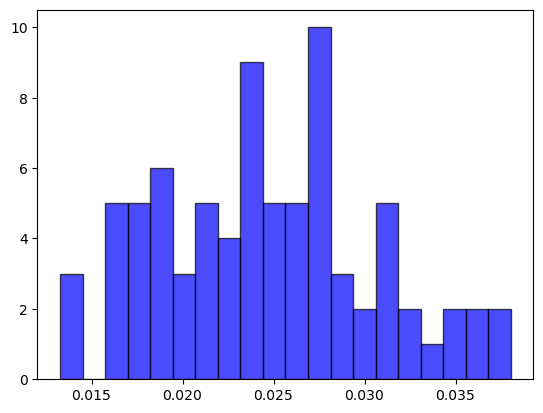

In [145]:
def compute_geometry_param_energy(curvature, POWER_ENG_CURVATURE=2):
    curvature_energy = np.mean(np.power(curvature, POWER_ENG_CURVATURE))
    return curvature_energy

curvature_energy = []
for i in range(len(curvatures)):
    c = curvatures[i]
    curvature_energy.append(compute_geometry_param_energy(c))
plt.hist(curvature_energy, bins=20, color='blue', edgecolor='black', alpha=0.7)

Given a series of curvature measurements along the internal carotid artery (ICA) centerline, denoted as \( \mathbf{c} = \{c_1, c_2, \ldots, c_n\} \), the initial step involves computing the cumulative sum \( S \) to expedite subsequent subarray summation calculations. Here, \( S_i \) represents the cumulative sum of the first \( i \) elements:
\[
S_i = \sum_{k=1}^i c_k
\]
with \( S_0 = 0 \) defined to simplify the handling of boundary conditions.

\subsection*{Calculation of Subarray Means}
For each possible subarray length \( l \) (ranging from 1 to \( n \)), we traverse all feasible starting positions \( j \) (ranging from 1 to \( n-l+1 \)) to compute the mean \( \mu \) of the subarray \( \mathbf{c}_{j:j+l-1} \):
\[
\mu = \frac{S_{j+l-1} - S_{j-1}}{l}
\]

\subsection*{Identification of the Longest Maximum Mean Subarray}
For every length \( l \), we record the starting \( j \) and ending position \( j+l-1 \) of the subarray that exhibits the highest mean \( \mu \). In cases where multiple positions yield the same mean value, the subarray closest to the start of the array is selected.

\subsection*{Algorithm Complexity}
The computational complexity of this method is \( O(n^2) \), where \( n \) represents the number of curvature data points. This quadratic complexity arises from the necessity to calculate the mean for all possible subarrays for every potential length.

\subsection*{Implementation Details}
A dynamic programming strategy was employed by precomputing cumulative sums, allowing constant time complexity for any subarray sum computation in subsequent steps. This approach significantly reduces the need for redundant calculations and optimizes the process of mean calculation.

Moreover, while the algorithm efficiently handles datasets with thousands of data points despite its quadratic computational complexity, future work may focus on further optimization or exploration of more efficient algorithms to manage larger datasets.

Through this method, we can determine the segment with the highest average curvature for each possible subarray length, providing a foundation for more detailed analysis and pattern recognition in the curvature data of the ICA. This approach is particularly useful in locating the siphon, a critical region known for its high curvature, thereby aiding in the accurate diagnosis and treatment planning in cerebrovascular care.


max elbow:  32
min elbow:  17
mean elbow:  23.544303797468356


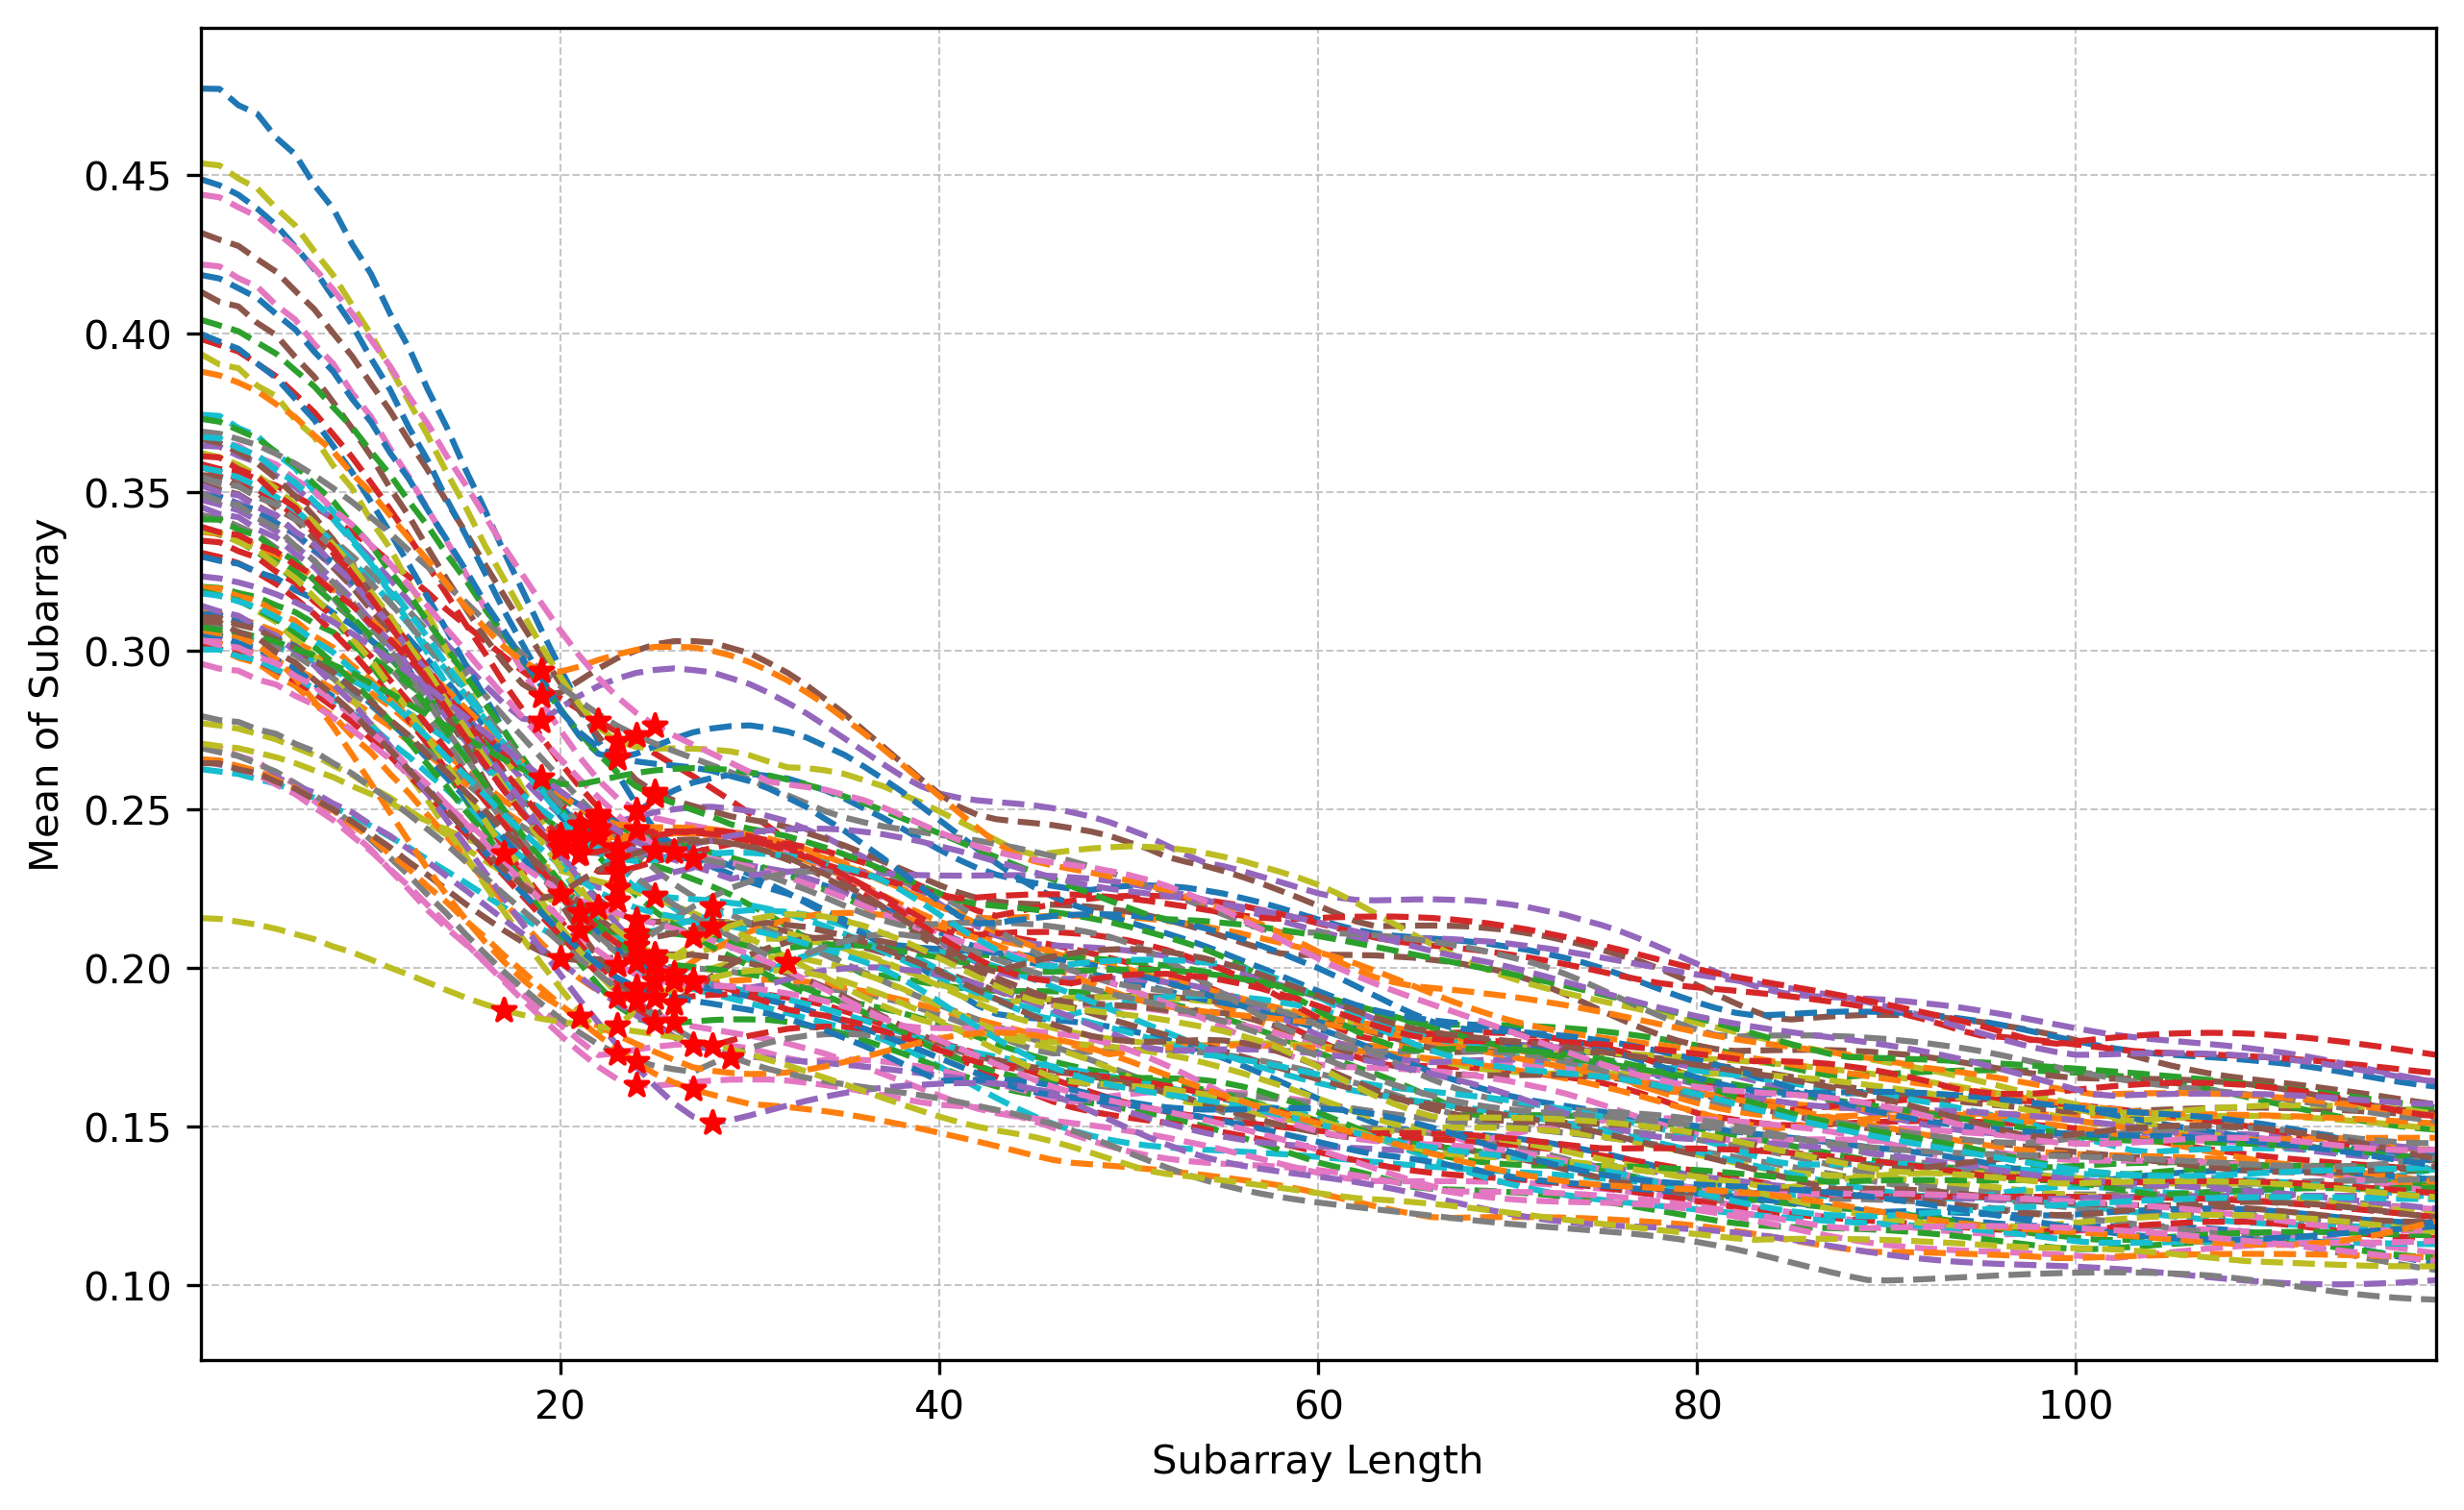

In [146]:
def find_longest_max_mean_subarray(curvature):
    """
    Find the longest subarray with the maximum mean for each possible subarray length.

    Parameters:
    - curvature: A 1D numpy array containing the curvature values.

    Returns:
    - A list of tuples, each containing the subarray and the start and end indices
      for the maximum mean subarray of each possible length.
    """
    n = len(curvature)
    max_subarrays = []

    # Precompute the cumulative sum of curvatures
    cumulative_sum = np.cumsum(curvature)
    cumulative_sum = np.insert(cumulative_sum, 0, 0)  # Insert 0 at the beginning for correct subarray sums

    # Iterate over all possible subarray lengths
    for l in range(1, n + 1):
        max_mean = float('-inf')
        max_start = 0
        max_end = l - 1  # Initialize to the first subarray of length l
        
        # Iterate over all possible start indices for subarrays of length l
        for start in range(0, n - l + 1):
            end = start + l - 1
            subarray_sum = cumulative_sum[end + 1] - cumulative_sum[start]
            cur_mean = subarray_sum / l
            
            # Update if we find a new maximum mean for the current length
            if cur_mean > max_mean or (cur_mean == max_mean and (end - start) > (max_end - max_start)):
                max_mean = cur_mean
                max_start, max_end = start, end
        
        # Store the best subarray for the current length
        max_subarrays.append((curvature[max_start:max_end + 1], (max_start, max_end)))
    
    return max_subarrays

def find_elbow_point(x, y, start_index):
    """
    A heuristic to find the elbow point in a curve starting from a given index.

    Parameters:
    - x: The x-coordinates of the data points.
    - y: The y-coordinates of the data points.
    - start_index: The index in the sequence from which to start looking for the elbow.

    Returns:
    - The x-coordinate of the identified elbow point, if any.
    """
    if start_index >= len(x):
        raise ValueError("start_index is out of the bounds of the data array")

    # Calculate differences between consecutive y-values
    diffs = np.diff(y)
    # Define a threshold as a percentage of the maximum y-value
    threshold = 0.01 * np.max(y)

    # Look for the elbow starting from the specified index
    for i in range(start_index, len(diffs)):
        if abs(diffs[i]) < threshold and (i == start_index or abs(diffs[i - 1]) >= threshold):
            # print("x[i + 1]: ", x[i + 1])
            return x[i + 1]  # Return x corresponding to the found elbow point
            

    return x[-1]  # Return the last point if no clear elbow is found after start_index


def plot_length_vs_mean_multiple(curvatures, ax=None):
    elbows = []
    if ax is None:
        ax = plt.gca()  # 获取当前轴，如果没有传入ax

    for i, curvature in enumerate(curvatures):
        max_subarrays = find_longest_max_mean_subarray(curvature)
        lengths = []
        means = []

        for subarray, (start_index, end_index) in max_subarrays:
            lengths.append(end_index - start_index + 1)
            means.append(np.mean(subarray))

        # 使用Seaborn绘制主线图
        sns.lineplot(x=lengths, y=means, linestyle='--',  ax=ax)
        
        # 确定并标记肘点
        elbow_x = find_elbow_point(lengths, means, 15)
        elbows.append(elbow_x)
        elbow_y = np.interp(elbow_x, lengths, means)  # 插值找到肘点的y值
        ax.scatter(elbow_x, elbow_y, color='red', zorder=5, marker="*")  # 用红星标记肘点
        
    # 打印肘点统计信息
    print("max elbow: ", max(elbows))
    print("min elbow: ", min(elbows))
    print("mean elbow: ", np.mean(elbows))

    # ax.legend()  # 确保图例显示

fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111)
plot_length_vs_mean_multiple(curvatures,ax)
ax.set_xlabel('Subarray Length')
ax.set_ylabel('Mean of Subarray')
# plt.title('Relationship between Subarray Length and Mean Curvature for Multiple Profiles')
ax.grid(linestyle='--', linewidth=0.5, alpha=0.7)
ax.autoscale(enable=True, axis='x', tight=True)
# plt.legend()
plt.show()

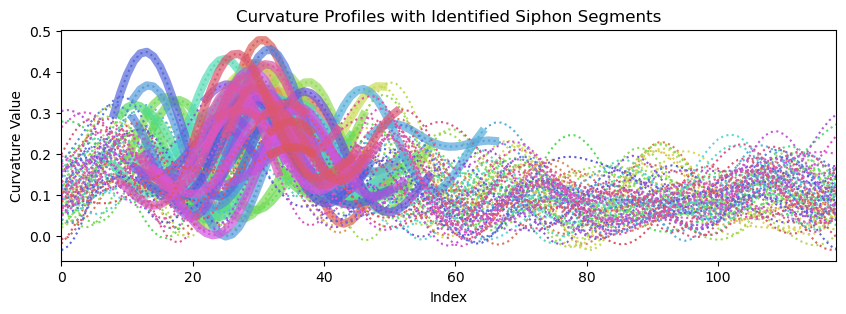

In [147]:
def identify_siphon_segment(curvature):
    max_subarrays = find_longest_max_mean_subarray(curvature)
    lengths = [end - start + 1 for _, (start, end) in max_subarrays]
    means = [np.mean(subarray) for subarray, _ in max_subarrays]

    # Determine the elbow point, starting from a reasonable index to skip initial fluctuations
    elbow_length = find_elbow_point(lengths, means, 5)
    elbow_index = lengths.index(elbow_length)
    max_subarray, (start_index, end_index) = max_subarrays[elbow_index]

    return max_subarray, (start_index, end_index)


fig = plt.figure(figsize=(10, 3), dpi=100)
ax = fig.add_subplot(111)
ax.autoscale(enable=True, axis='x', tight=True)

# Store a color palette with enough colors for all profiles
palette = sns.color_palette("hls", len(curvatures))

siphon_max_curvatures = []
siphon_mean_curvatures = []
siphon_curvatures = []


for i, curvature in enumerate(curvatures):
    # Calculate max subarrays and siphon segment first
    max_subarrays = find_longest_max_mean_subarray(curvature)
    siphon_segment, (start, end) = identify_siphon_segment(curvature)
    siphon_curvatures.append(siphon_segment)
    siphon_max_curvatures.append(max(curvature[start:end + 1]))
    siphon_mean_curvatures.append(np.mean(curvature[start:end + 1]))
    x_range = range(start, end + 1)

    # Plot the curvature profile
    
    sns.lineplot(x=range(len(curvature)), y=curvature, linestyle=':', ax=ax,  color=palette[i])

    # Plot the siphon segment
    sns.lineplot(x=x_range, y=siphon_segment, linewidth=6, alpha=0.7, ax=ax,  color=palette[i])
    l = np.argmax(curvature)
    n = files[i].split('\\')[-1]
    # ax.annotate(n, (l, curvature[l]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=6)
    is_siphon = np.zeros(len(curvature),dtype=int)
    is_siphon[x_range] = 1
    makeVtkFile('../is_Siphon/'+n+'.vtk',curve_cs[i],[['isSiphon', 'int', is_siphon]])
    

ax.set_xlabel('Index')
ax.set_ylabel('Curvature Value')
plt.title('Curvature Profiles with Identified Siphon Segments')
plt.show()

siphon_max_curvatures = np.array(siphon_max_curvatures)
siphon_mean_curvatures = np.array(siphon_mean_curvatures)




(79,)
(79,)
(79,)
(79,)
Mean vs Max Curvature: Correlation Coefficient = 0.41, p-value = 0.00016
Siphon Mean vs Siphon Max Curvature: Correlation Coefficient = 0.31, p-value = 0.00603
Siphon Mean vs Mean Curvature: Correlation Coefficient = 0.53, p-value = 0.00000
Siphon Max vs Max Curvature: Correlation Coefficient = 0.97, p-value = 0.00000


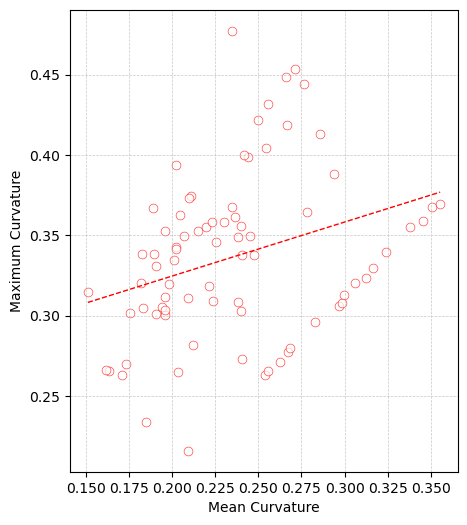

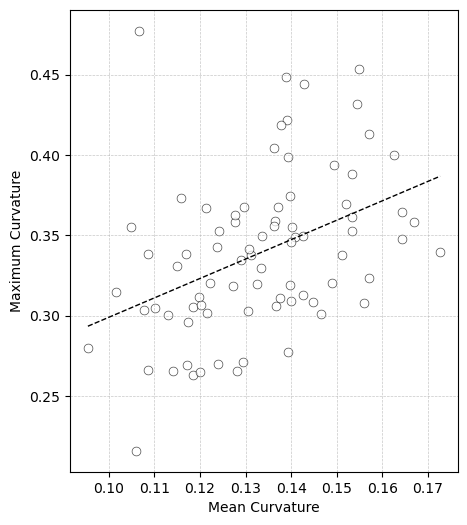

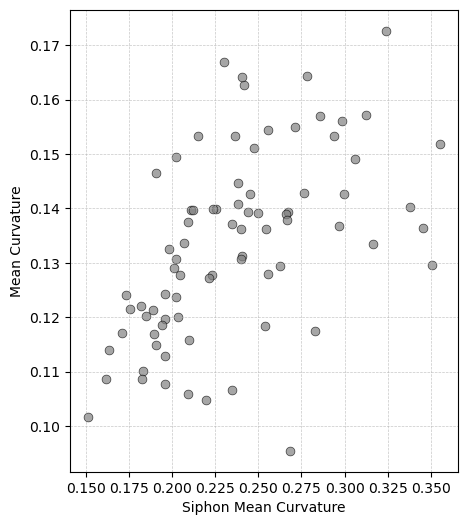

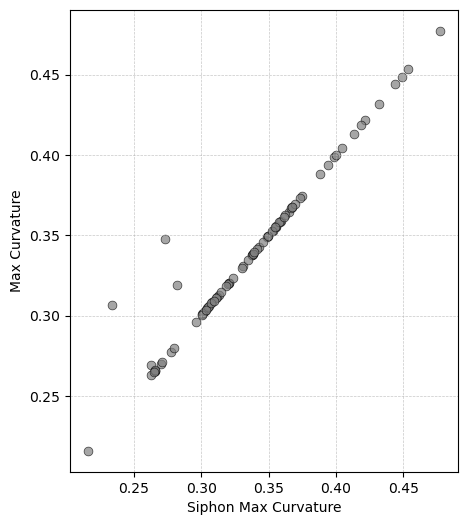

In [148]:
import scipy.stats as stats

mean_curvature = np.mean(curvatures, axis=1)
max_curvature = np.max(curvatures, axis=1)
print (mean_curvature.shape)
print (max_curvature.shape)
print (siphon_mean_curvatures.shape)
print (siphon_max_curvatures.shape)

# 线性回归拟合
coefficients_mean_max = np.polyfit(mean_curvature, max_curvature, 1)
poly_mean_max = np.poly1d(coefficients_mean_max)

coefficients_siphon = np.polyfit(siphon_mean_curvatures, siphon_max_curvatures, 1)
poly_siphon = np.poly1d(coefficients_siphon)

# 生成线性拟合数据
fit_values_mean_max = poly_mean_max(mean_curvature)
fit_values_siphon = poly_siphon(siphon_mean_curvatures)

# 计算相关系数和p-value
corr_coef1, p_value1 = stats.pearsonr(mean_curvature, max_curvature)
corr_coef2, p_value2 = stats.pearsonr(siphon_mean_curvatures, siphon_max_curvatures)
corr_coef3, p_value3 = stats.pearsonr(siphon_mean_curvatures, mean_curvature)
corr_coef4, p_value4 = stats.pearsonr(siphon_max_curvatures, max_curvature)

# 打印相关系数和p-value
print(f"Mean vs Max Curvature: Correlation Coefficient = {corr_coef1:.2f}, p-value = {p_value1:.5f}")
print(f"Siphon Mean vs Siphon Max Curvature: Correlation Coefficient = {corr_coef2:.2f}, p-value = {p_value2:.5f}")
print(f"Siphon Mean vs Mean Curvature: Correlation Coefficient = {corr_coef3:.2f}, p-value = {p_value3:.5f}")
print(f"Siphon Max vs Max Curvature: Correlation Coefficient = {corr_coef4:.2f}, p-value = {p_value4:.5f}")
fig = plt.figure(figsize=(5, 6), dpi=100)
ax = fig.add_subplot(111)
sns.scatterplot(x=siphon_mean_curvatures, y=siphon_max_curvatures, s=40, color='white', alpha=0.7, ax=ax,edgecolor='red')
sns.lineplot(x=siphon_mean_curvatures, y=fit_values_siphon, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Mean Curvature')
ax.set_ylabel('Maximum Curvature')
ax.grid(linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

fig = plt.figure(figsize=(5, 6), dpi=100)
ax = fig.add_subplot(111)
sns.scatterplot(x=mean_curvature, y=max_curvature, s=40, color='white', alpha=0.7, ax=ax,edgecolor='black') 
# 绘制拟合线
sns.lineplot(x=mean_curvature, y=fit_values_mean_max, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Mean Curvature')
ax.set_ylabel('Maximum Curvature')
ax.grid(linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()



fig = plt.figure(figsize=(5, 6), dpi=100)
ax = fig.add_subplot(111)
sns.scatterplot(x=siphon_mean_curvatures, y=mean_curvature, s=40, color='gray', alpha=0.7, ax=ax,edgecolor='black',marker='o')
ax.set_xlabel('Siphon Mean Curvature')
ax.set_ylabel('Mean Curvature')
ax.grid(linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()


fig = plt.figure(figsize=(5, 6), dpi=100)
ax = fig.add_subplot(111)
sns.scatterplot(x=siphon_max_curvatures, y=max_curvature, s=40, color='gray', alpha=0.7, ax=ax,edgecolor='black',marker='o')
ax.set_xlabel('Siphon Max Curvature')
ax.set_ylabel('Max Curvature')
ax.grid(linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()


In [149]:
# 重新排列

g_dist_to_frechet = []
for i in range(len(curve_cs)):
    g_dist_to_frechet.append(curves_r3.metric.dist(mean_estimate, curve_cs[i]))
g_dist_to_frechet = np.array(g_dist_to_frechet)

# 获取按距离从小到大排序的索引
sorted_indices = np.argsort(g_dist_to_frechet)

# 根据这些索引重新排列距离数组
g_dist_to_frechet = g_dist_to_frechet[sorted_indices]

# 对曲率进行相应的从大到小排序

curvatures = curvatures[sorted_indices]
files = files[sorted_indices]
curve_cs = curve_cs[sorted_indices]

curve_bs = curve_bs[sorted_indices]



(62, 78) (76, 78)


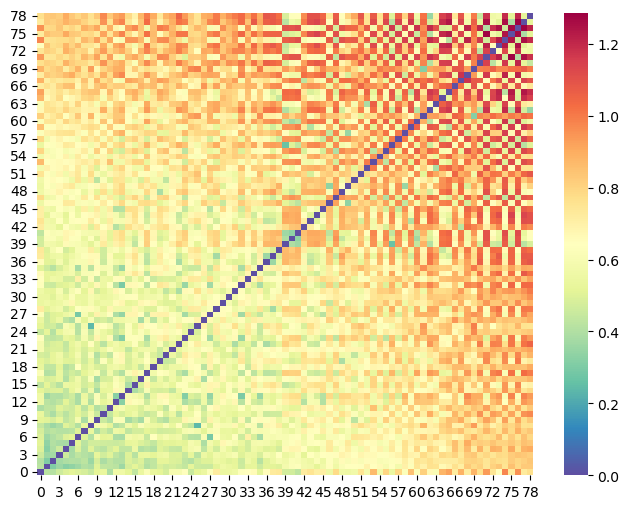

In [150]:
g_dist_min = 100000
g_dist_max = 0
g_dist_min_index = (0,0)
g_dist_max_index = (0,0)
g_dist = []
g_dist_mat = np.zeros((len(curve_bs),len(curve_bs)))
for i in range(len(curve_bs)):
    # geodesic_distance = curves_r3.metric.dist(mean_estimate, curve_bs[i])
    for j in range(len(curve_bs)):
        g_dist_mat[i,j] = curves_r3.metric.dist(curve_bs[i], curve_bs[j])
    
    if i != j and g_dist_mat[i,j] < g_dist_min:
        g_dist_min = g_dist_mat[i,j]
        g_dist_min_index = (i,j)
    elif i != j and g_dist_mat[i,j] > g_dist_max:
        g_dist_max = g_dist_mat[i,j]
        g_dist_max_index = (i,j)
    g_dist.append(g_dist_mat[i,j])
print (g_dist_min_index, g_dist_max_index)
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
sns.heatmap(g_dist_mat,ax=ax, cmap='Spectral_r')
ax.invert_yaxis()

g_dist_center = np.mean(g_dist_mat, axis=0)

Pearson correlation coefficient: 0.5787033514401079
P-value: 5.3934227337980636e-275


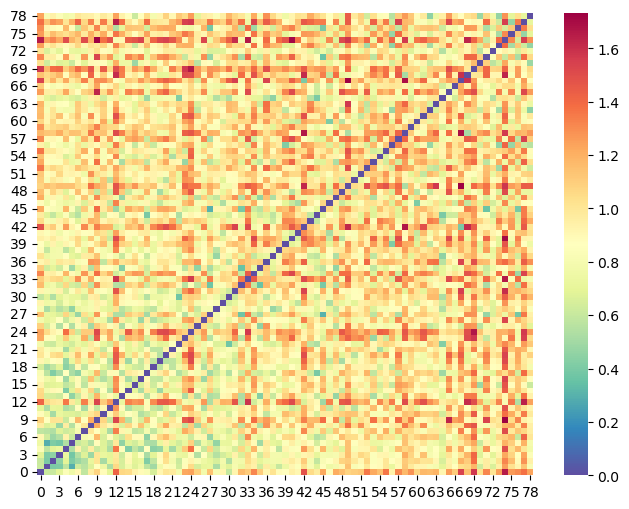

In [151]:
# 假设 curvatures 是已定义的列表，calculate_l2_distance 是已定义的函数
num_curvatures = len(curvatures)
curvature_l2_dist_mat = np.zeros((num_curvatures, num_curvatures))  # 创建一个大小正确的方阵

for i in range(num_curvatures):
    for j in range(i + 1, num_curvatures):
        d = calculate_l2_distance(curvatures[i], curvatures[j])
        curvature_l2_dist_mat[i, j] = d
        curvature_l2_dist_mat[j, i] = d  # 填充对称元素

# curvature_l2_dist_mat = np.array(curvature_l2_dist_mat).reshape(len(curvatures),len(curvatures))
upper_tri_indices = np.triu_indices_from(g_dist_mat, k=1)  # k=1表示不包括对角线

# 获取对应的一维数组
g_dist_flattened = g_dist_mat[upper_tri_indices]
curvature_l2_dist_flattened = curvature_l2_dist_mat[upper_tri_indices]

# 计算皮尔逊相关系数
correlation_coefficient, p_value = stats.pearsonr(g_dist_flattened, curvature_l2_dist_flattened)

# 打印结果
print("Pearson correlation coefficient:", correlation_coefficient)
print("P-value:", p_value)

fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
sns.heatmap(curvature_l2_dist_mat,ax=ax, cmap='Spectral_r')
ax.invert_yaxis()

参考用


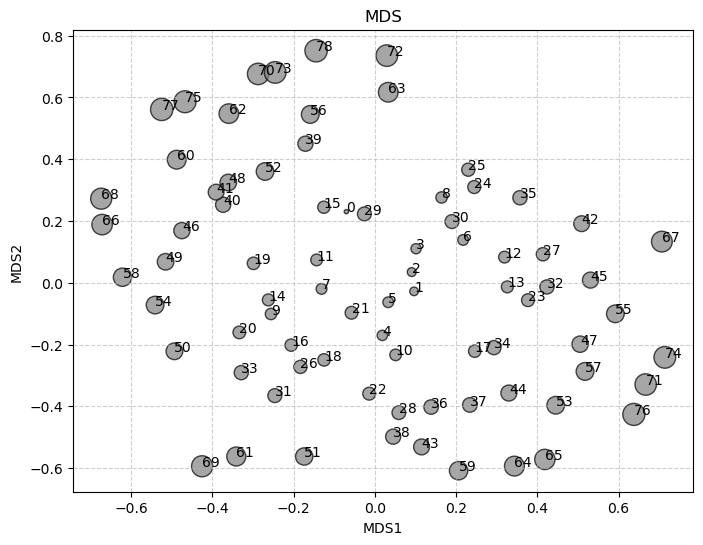

In [152]:
from sklearn.manifold import MDS

print ("参考用")
# 初始化MDS模型，设置降维到2维
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)

# 对距离矩阵应用MDS算法
results = mds.fit_transform(g_dist_mat)

# 提取两个维度
x = results[:, 0]
y = results[:, 1]

# 绘制结果
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c="gray",alpha=0.7,s=g_dist_to_frechet*g_dist_to_frechet*500,edgecolors='black')
# plt.plot(x, y, 'k', linewidth=0.5)
for i in range(len(results)):
    plt.annotate(i, (x[i], y[i]))
plt.title('MDS')
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.grid(linestyle='--', alpha=0.6 )
# for i, txt in enumerate(range(1, g_dist_mat.shape[0]+1)):
#     plt.annotate(ruptureStatus[i], (x[i], y[i]))
# plt.savefig(root_dir+'MDS.png')
# plt.close()

(79, 10)


array([0.39690109, 0.20759248, 0.18275613, 0.07918031, 0.02633007,
       0.02272125, 0.02095439, 0.01317999, 0.01198089, 0.00757386])

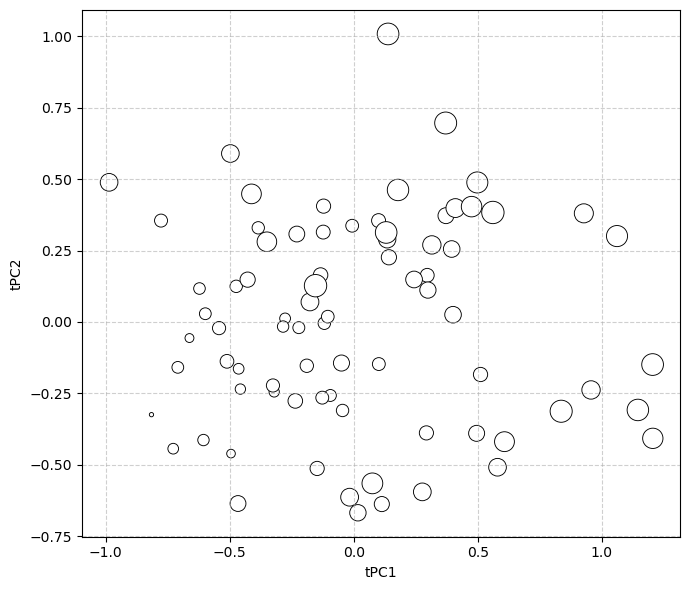

In [157]:
tPCA_N_COMPONENTS = 10

tpca = TangentPCA(curves_r3, n_components=tPCA_N_COMPONENTS)
tpca.fit(curve_cs, base_point=tangent_base)
tangent_projected_data = tpca.transform(curve_cs)

print (tangent_projected_data.shape)
# 步骤4: 分析和可视化结果
fig = plt.figure(figsize=(7, 6), dpi=100)
ax1 = fig.add_subplot(111)
sns.scatterplot(x=tangent_projected_data[:, 0], y=tangent_projected_data[:, 1], c='white',edgecolor='black',s=g_dist_to_frechet*g_dist_to_frechet*500,ax=ax1)
# ax1.plot(tangent_projected_data[:, 0], tangent_projected_data[:, 1], 'r--', linewidth=0.5)
# for i in range(len(tangent_projected_data)):
#     ax1.annotate(i, (tangent_projected_data[i, 0], tangent_projected_data[i, 1]))
ax1.grid(linestyle='--', alpha=0.6 )
ax1.set_xlabel('tPC1')
ax1.set_ylabel('tPC2')
plt.tight_layout()
tpca.explained_variance_ratio_

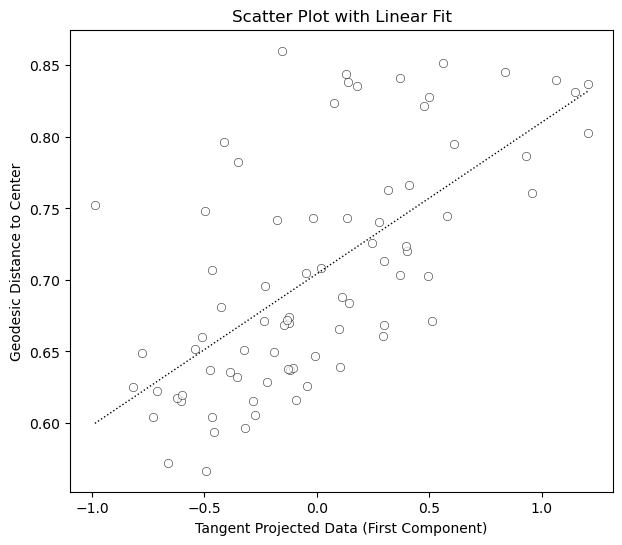

Slope: 0.10592140099579869
Intercept: 0.7043209254067974
R-squared: 0.42650636498044747
R-value (Correlation coefficient): 0.6530745477971466
P-value: 6.895479965203468e-11
Standard error: 0.01399715901921816


In [158]:
# plt.scatter(tangent_projected_data[:,0], g_dist_center, c='white', alpha=0.7, edgecolors='black')


X = tangent_projected_data[:, 0]  # 取第一列数据为X
Y = g_dist_center                 # Y数据
regression_result = linregress(X, Y)
# 绘制散点图和拟合线
fig = plt.figure(figsize=(7, 6), dpi=100)
ax = fig.add_subplot(111)
sns.scatterplot(x=X, y=Y, ax=ax, c='white', alpha=0.7, edgecolor='black')
sns.lineplot(x=X, y=regression_result.intercept + regression_result.slope*X, color='k',linewidth=1, linestyle=":")  # 拟合线
plt.title('Scatter Plot with Linear Fit')
plt.xlabel('Tangent Projected Data (First Component)')
plt.ylabel('Geodesic Distance to Center')
plt.show()


# 打印拟合结果和统计数据
print(f"Slope: {regression_result.slope}")
print(f"Intercept: {regression_result.intercept}")
print(f"R-squared: {regression_result.rvalue**2}")
print(f"R-value (Correlation coefficient): {regression_result.rvalue}")
print(f"P-value: {regression_result.pvalue}")
print(f"Standard error: {regression_result.stderr}")

(200, 10)


d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


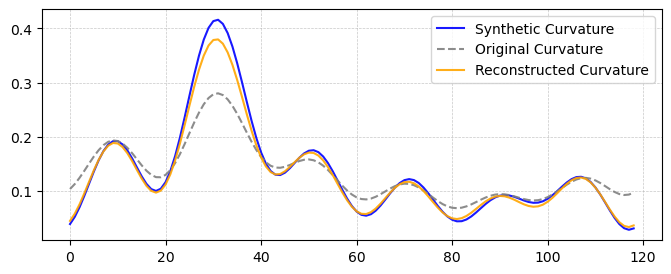

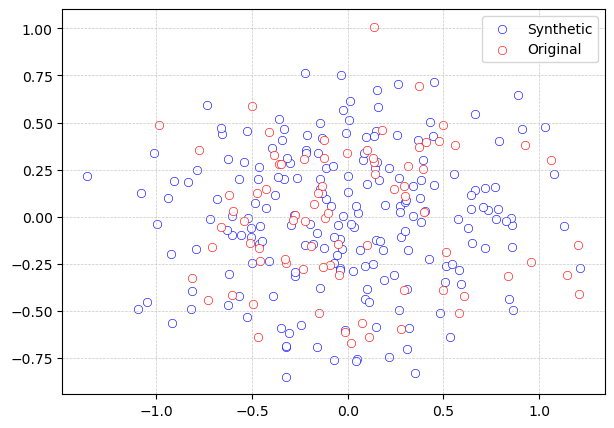

In [230]:
from scipy.stats import norm

def fit_gaussian(data):
    # 计算数据的均值和标准差
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)

    # 创建一个高斯分布对象数组
    gaussians = [norm(loc=mean[i], scale=std[i]) for i in range(len(mean))]
    return gaussians

def from_tangentPCA_feature_to_curves(tpca, tangent_base, tangent_projected_data, PCA_N_COMPONENTS, discrete_curves_space):
    principal_components = tpca.components_
    # Assuming principal_components has the shape (n_components, n_sampling_points * n_dimensions)
    point_num = len(tangent_base)
    principal_components_reshaped = principal_components.reshape((PCA_N_COMPONENTS, point_num, 3)) # point_num是采样点数
    # Now use exp on each reshaped component
    curves_from_components = [
        discrete_curves_space.metric.exp(tangent_vec=component, base_point=tangent_base)
        for component in principal_components_reshaped
    ]

    reconstructed_curves = []
    for idx in range(len(tangent_projected_data)):
        # This is your feature - a single point in PCA space representing the loadings for the first curve.
        feature = np.array(tangent_projected_data[idx])
        # Reconstruct the tangent vector from the feature.
        # print ("feature:", feature.shape)
        # print ("principal_components_reshaped:", principal_components_reshaped.shape)
        # print ("idx:", idx)
        tangent_vector_reconstructed = sum(feature[i] * principal_components_reshaped[i] for i in range(len(feature)))
        # Map the tangent vector back to the curve space using the exponential map.
        reconstructed_curve = discrete_curves_space.metric.exp(
            tangent_vec=tangent_vector_reconstructed, base_point=tangent_base
        )
        # reconstructed_curve = inverse_srvf(reconstructed_srvf, np.zeros(3))
        # print ("reconstructed_curve length:", measure_length(reconstructed_curve))# length=63
        
        reconstructed_curves.append(reconstructed_curve)
    reconstructed_curves = np.array(reconstructed_curves)
    return reconstructed_curves

tangent_pca_gaussian = fit_gaussian(tangent_projected_data)
# 从每个高斯分布中独立采样
sample_num = 200  # 定义您想要的样本数
synthetic_features = np.array([g.rvs(sample_num) for g in tangent_pca_gaussian]).T
print (synthetic_features.shape)
# tangent_base = mean_estimate
discrete_curves_space = curves_r3

reconstructed_synthetic_curves = from_tangentPCA_feature_to_curves(tpca, tangent_base, synthetic_features, 
                                                                              tPCA_N_COMPONENTS, 
                                                                              discrete_curves_space)

reconstructed_curves = from_tangentPCA_feature_to_curves(tpca, tangent_base, tangent_projected_data, 
                                                                              tPCA_N_COMPONENTS, 
                                                                              discrete_curves_space)


K = 100 # 140
synthetic_curvatures = []
for i in range(len(reconstructed_synthetic_curves)):
    c,t = compute_curvature_and_torsion(reconstructed_synthetic_curves[i]*K)
    fft_c = remove_high_freq_components(c,0.055)
    synthetic_curvatures.append(fft_c)
synthetic_curvatures = np.array(synthetic_curvatures)

synthetic_g_dist_mat = np.zeros((len(reconstructed_synthetic_curves),len(reconstructed_synthetic_curves)))
for i in range(len(reconstructed_synthetic_curves)):
    for j in range(len(reconstructed_synthetic_curves)):
        synthetic_g_dist_mat[i,j] = curves_r3.metric.dist(reconstructed_synthetic_curves[i], reconstructed_synthetic_curves[j])

reconstructed_curvatures = []
for i in range(len(reconstructed_curves)):
    c,t = compute_curvature_and_torsion(reconstructed_curves[i]*K)
    fft_c = remove_high_freq_components(c,0.055)
    reconstructed_curvatures.append(fft_c)

fig = plt.figure(figsize=(8, 3), dpi=100)
ax = fig.add_subplot(111)
sns.lineplot(x=range(len(curvatures[0])),y=np.mean(synthetic_curvatures,axis=0),c='b', alpha=0.9, label='Synthetic Curvature',ax=ax)
sns.lineplot(x=range(len(curvatures[0])),y=np.mean(curvatures,axis=0),c='gray',linestyle='--', alpha=0.9, label='Original Curvature',ax=ax)
sns.lineplot(x=range(len(curvatures[0])),y=np.mean(reconstructed_curvatures,axis=0),c='orange', alpha=0.9, label='Reconstructed Curvature',ax=ax)
# plt.legend()
plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
sns.scatterplot(x=synthetic_features[:,0],y=synthetic_features[:,1],c='white', edgecolor="b", alpha=0.9, label='Synthetic',ax=ax)
sns.scatterplot(x=tangent_projected_data[:,0],y=tangent_projected_data[:,1],c='white', edgecolor="r",alpha=0.9, label='Original',ax=ax)
plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)

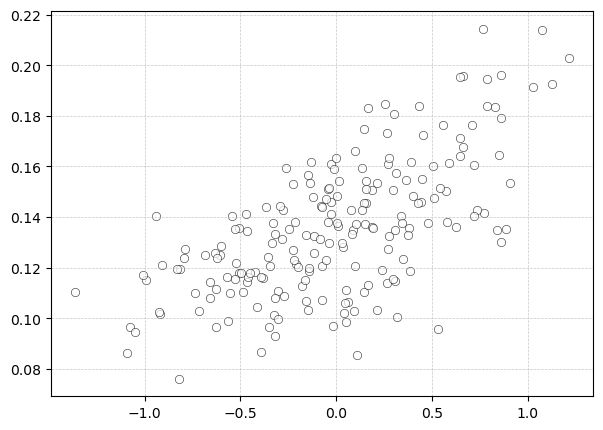

<Axes: >

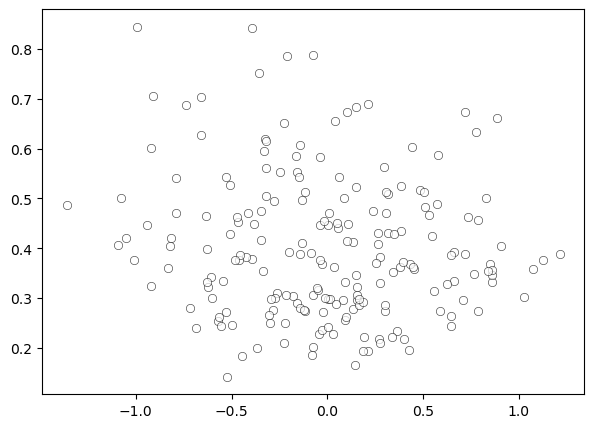

In [254]:
max_synthetic_curvatures = np.max(synthetic_curvatures, axis=1)
max_reconstructed_curvatures = np.max(reconstructed_curvatures, axis=1)
mean_synthetic_curvatures = np.mean(synthetic_curvatures, axis=1)
mean_reconstructed_curvatures = np.mean(reconstructed_curvatures, axis=1)

fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
sns.scatterplot(x=synthetic_features[:,0], y=mean_synthetic_curvatures, c='white', edgecolor='black',alpha=0.7,ax=ax)
# sns.scatterplot(x=synthetic_features[:,0], y=mean_synthetic_curvatures, c='white', edgecolor='black',alpha=0.7,ax=ax,marker='s')
# sns.scatterplot(x=tangent_projected_data[:,0], y=mean_curvature, c='white', edgecolor='blue',alpha=0.9,ax=ax)
# sns.scatterplot(x=synthetic_features[:,0], y=max_synthetic_curvatures, c='gray', edgecolor='black',alpha=0.7,ax=ax)
plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

g_dist_synthetic = []
for i in range(len(reconstructed_synthetic_curves)):
    g_dist_synthetic.append(curves_r3.metric.dist(mean_estimate, reconstructed_synthetic_curves[i]))

fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
sns.scatterplot(x=synthetic_features[:,0], y=g_dist_synthetic, c='white', edgecolor='black',alpha=0.7,ax=ax)

In [156]:
# import numpy as np
# from scipy.optimize import minimize
# from scipy.optimize import differential_evolution

# # 假设 calculate_fisher_rao_distance 已经定义
# def calculate_fisher_rao_distance(shape1, shape2):
#     # 这里应该是你的Fisher-Rao距离计算实现
#     return np.linalg.norm(shape1 - shape2)  # 仅为示例，需要替换为正确的计算方法

# # 目标函数：最小化生成形状与训练形状间距离的误差
# def objective_function(generated_shape, train_shapes, test_dist_vec):
#     generated_shape = generated_shape.reshape(-1, 3)  # 确保形状正确
#     distances = [calculate_fisher_rao_distance(generated_shape, train_shape) for train_shape in train_shapes]
#     error = np.linalg.norm(np.array(distances) - test_dist_vec)
#     return error

# # 训练形状数据和测试距离向量
# train_shapes = np.array(curve_cs)  # curve_cs 是已给出的训练形状数组
# test_dist_vec = np.array(g_dist_center)  # g_dist_center 是给定的测试距离向量

# # 初始形状
# initial_shape = np.random.rand(119, 3).flatten()  # 展平以适配优化器

# # 运行全局优化
# result = differential_evolution(
#     objective_function,  # 目标函数
#     bounds=[(-0.4, 0.3)] * (119 * 3),  # 每个坐标的界限，这里假设每个坐标都在0到1之间
#     args=(train_shapes, test_dist_vec),  # 传递额外的参数
#     strategy='best1bin',
#     maxiter=1000,
#     popsize=15,
#     tol=0.01,
#     mutation=(0.5, 1),
#     recombination=0.7,
#     disp=True,
#     seed=None
# )

# # 优化后的形状
# optimized_shape = result.x.reshape(-1, 3)

# # 输出优化结果和最终形状
# print("Optimization success:", result.success)
# print("Final shape:", optimized_shape)
